In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression

In [3]:
N = 5000
u = np.random.normal(size=N)

p_d = 1./(1. + np.exp(-u))
d = np.random.binomial(1, p=p_d)

p_z = 1./(1. + np.exp(-(d + 0.1 * np.random.normal(size=N))))
z = np.random.binomial(1, p=p_z)

y = 2. * u + 2.*z + 0.2* np.random.normal(size=N) 
df = pd.DataFrame({'D': d, 'Y': y, 'Z': z})

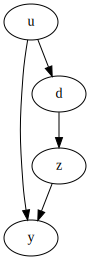

In [12]:
from causalgraphicalmodels import CausalGraphicalModel
G = CausalGraphicalModel(
    nodes = ['d', 'z', 'y', 'u'],
    edges = [
        ('d', 'z'),
        ('u', 'd'),
        ('u', 'y'),
        ('z', 'y')
    ]
)
G.draw()

In [4]:
df[df['D'] == 1].mean()

D    1.000000
Y    2.291136
Z    0.723742
dtype: float64

In [5]:
df[df['D'] == 0].mean()

D    0.000000
Y    0.200167
Z    0.512313
dtype: float64

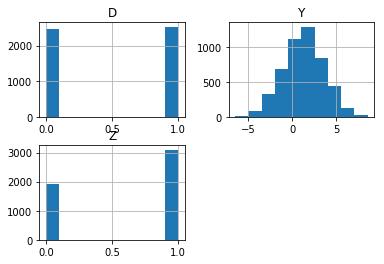

In [6]:
df.hist();

We want to estimate $E(Y|do(D=d)) = \sum_Z P(Z|D) \sum_{D'} E[Y|D', Z]P(D') = \sum_Z P(Z|D) P(Y|do(Z=z))$, so we need each component. Y is real-valued, but Z and X are discrete (binary).

* $P(Z|D)$ we can use a logistic regression
* $E[Y|D', Z]$ we can use linear regression 
* $\sum_{D'}E[Y|D', Z] P(D')$ we can do our usual trick, so we don't have to compute P(D'), or since it's discrete, we can just calculate it

Let's start with $P(Z|D)$.

### What do we do first? CHECK SUPPORT

We're measuring two effects, so we should check both. We need P(Y, Z) >0, and P(Z, D) > 0.





Z
0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

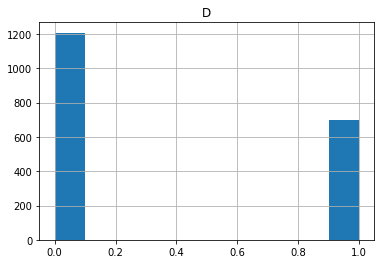

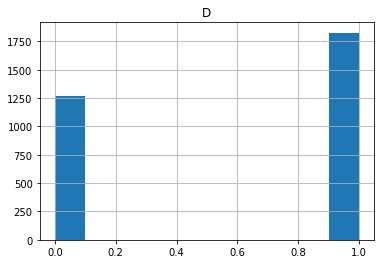

In [7]:
df.groupby('Z').hist('D')

Z
0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

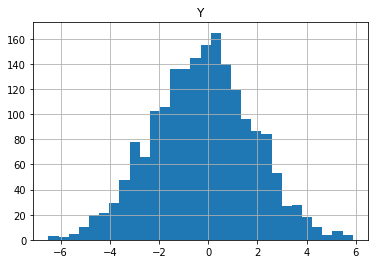

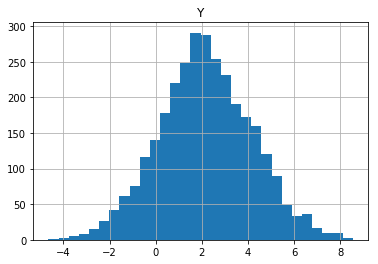

In [8]:
df.groupby('Z').hist('Y', bins=30)

The support isn't great on the high and low side of Y, but the density there is small, and we'll plan to extrapolate with our models. That's always something to be concerned about! If the extrapolation fails, your estimator is probably biased.

In [24]:
p_z_given_d = LogisticRegression(C=1e12)
p_z_given_d = p_z_given_d.fit(df[['D']], df['Z'])
df["$P(Z|D)$"] = p_z_given_d.predict_proba(df[['D']])[:,1]
df.head()

,D,Y,Z,$P(Z|D)$
0,1,-4.533230,0,0.729006
1,0,3.140879,0,0.473767
2,1,1.605166,1,0.729006
3,1,-0.286409,1,0.729006
4,1,4.980968,1,0.729006


Now let's get $E[Y|D', Z]$

In [25]:
y_given_d_z = LinearRegression()
y_given_d_z = y_given_d_z.fit(df[['D', 'Z']], df['Y'])
df["$E[Y| D', Z]$"] = y_given_d_z.predict(df[['D', 'Z']])

In [26]:
df

,D,Y,Z,$P(Z|D)$,"$E[Y| D', Z]$"
0,1,-4.533230,0,0.729006,0.041417
1,0,3.140879,0,0.473767,-0.020044
2,1,1.605166,1,0.729006,2.020643
3,1,-0.286409,1,0.729006,2.020643
4,1,4.980968,1,0.729006,2.020643
5,1,4.250381,0,0.729006,0.041417
6,1,3.090742,0,0.729006,0.041417
7,1,3.819545,1,0.729006,2.020643
8,0,-0.849525,1,0.473767,1.959182
9,1,-0.963905,1,0.729006,2.020643


In [27]:
p_d = df.groupby('D').count()['Y'] / len(df)
p_d

D
0    0.507
1    0.493
Name: Y, dtype: float64

Let's do D=1. We see $P(D=1) = 0.485$

In [28]:
# compute E[Y|do(Z=z)] for each z. We need to perform the sum over D'.
from collections import defaultdict

E_y_do_z = defaultdict(lambda : 0.)

for zi in df['Z'].unique():
    for di in df['D'].unique():
        E_y_do_z[zi] += y_given_d_z.predict([[di, zi]])[0] * p_d[di]
        

In [29]:
# Now, we can evaluate the outer sum
E_y_do_d = defaultdict(lambda : 0.)
for di in df['D'].unique():
    for zi in df['Z'].unique():
        E_y_do_d[di] += E_y_do_z[zi] * p_z_given_d.predict_proba([[di]])[0][1]


In [30]:
E_y_do_d

defaultdict(<function __main__.<lambda>()>,
            {1: 1.4578216071071353, 0: 0.9474107541835669})

In [31]:
# We can check by intervening! Then, the naive estimator should work.

N = 5000
u = np.random.normal(size=N)

p_d = 0.5 # 1./(1. + np.exp(-u)) replace with random assignment to break confounding, keep the same marginal of p(D)
d = np.random.binomial(1, p=p_d, size=N)

p_z = 1./(1. + np.exp(-(d + 0.1 * np.random.normal(size=N))))
z = np.random.binomial(1, p=p_z)

y = 2. * u + 2.*z + 0.2* np.random.normal(size=N) 
df = pd.DataFrame({'D': d, 'Y': y, 'Z': z})

In [32]:
df[df['D'] == 1].mean()['Y']

1.4856785467485223

In [33]:
df[df['D'] == 0].mean()['Y']

0.9202351316470208